# Wisconsin Breast Cancer - Kümeleme Analizi

Bu notebook'ta meme kanseri veri seti üzerinde K-Means ve DBSCAN kümeleme algoritmaları uygulanacaktır.

## Kullanılan Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("✓ Tüm kütüphaneler başarıyla yüklendi")

✓ Tüm kütüphaneler başarıyla yüklendi


## 1. Veri Hazırlığı

Wisconsin Breast Cancer veri seti yükleniyor ve temel istatistikler inceleniyor.

In [ ]:
# Veri yükleme
data = load_breast_cancer()
X = data.data
y = data.target  # Gerçek etiketler (değerlendirme için)
feature_names = data.feature_names

# Veri hakkında bilgi
print("="*70)
print("VERİ SETİ BİLGİLERİ")
print("="*70)
print(f"Toplam örnek sayısı: {X.shape[0]}")
print(f"Özellik sayısı: {X.shape[1]}")
print(f"\nSınıf Dağılımı:")
print(f"  Malignant (Kötü huylu): {sum(y==0)} örnek")
print(f"  Benign (İyi huylu): {sum(y==1)} örnek")

# İlk birkaç özelliğe bakalım
df = pd.DataFrame(X[:, :5], columns=feature_names[:5])
print("\nİlk 5 Özelliğin İlk 3 Satırı:")
print(df.head(3))

VERİ SETİ BİLGİLERİ
Toplam örnek sayısı: 569
Özellik sayısı: 30

Sınıf Dağılımı:
  Malignant (Kötü huylu): 212 örnek
  Benign (İyi huylu): 357 örnek

İlk 5 Özelliğin İlk 3 Satırı:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness
0        17.99         10.38           122.8     1001.0          0.11840
1        20.57         17.77           132.9     1326.0          0.08474
2        19.69         21.25           130.0     1203.0          0.10960


## 2. Veri Ön İşleme

Kümeleme algoritmaları uzaklık tabanlı çalıştığı için veriler normalize ediliyor.
StandardScaler: ortalama=0, standart sapma=1

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Veriler StandardScaler ile normalize edildi")
print(f"Normalize edilmiş veri boyutu: {X_scaled.shape}")
print(f"Ortalama: {X_scaled.mean():.4f}")
print(f"Standart sapma: {X_scaled.std():.4f}")

✓ Veriler StandardScaler ile normalize edildi
Normalize edilmiş veri boyutu: (569, 30)
Ortalama: -0.0000
Standart sapma: 1.0000


## 3. Boyut İndirgeme

Görselleştirme için PCA ile 30 boyut -> 2 boyuta indirgeniyor.
Not: Asıl kümeleme 30 boyutlu veri üzerinde yapılacak.

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("✓ PCA ile boyut indirgeme tamamlandı")
print(f"Orijinal boyut: {X_scaled.shape[1]} -> PCA sonrası: {X_pca.shape[1]}")
print(f"Birinci bileşen varyans oranı: {pca.explained_variance_ratio_[0]:.2%}")
print(f"İkinci bileşen varyans oranı: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Toplam açıklanan varyans: {sum(pca.explained_variance_ratio_):.2%}")

✓ PCA ile boyut indirgeme tamamlandı
Orijinal boyut: 30 -> PCA sonrası: 2
Birinci bileşen varyans oranı: 44.27%
İkinci bileşen varyans oranı: 18.97%
Toplam açıklanan varyans: 63.24%


## 4. Optimal Küme Sayısı Belirleme

### 4.1. Elbow Yöntemi
K değerleri için inertia (küme içi kareler toplamı) hesaplanıyor.

In [ ]:
inertias = []
K_range = range(2, 11)

print("ELBOW YÖNTEMİ")
print("="*50)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"k={k}: Inertia = {kmeans.inertia_:.2f}")

ELBOW YÖNTEMİ
k=2: Inertia = 11595.53
k=3: Inertia = 10061.80
k=4: Inertia = 9258.99
k=5: Inertia = 8558.66
k=6: Inertia = 7970.26
k=7: Inertia = 7540.32
k=8: Inertia = 7254.33
k=9: Inertia = 6837.63
k=10: Inertia = 6603.40


### 4.2. Silhouette Skoru

Silhouette skoru kümelerin ne kadar iyi ayrıldığını gösterir.
Değer aralığı: [-1, 1] (1'e yakın = iyi kümeleme)


In [ ]:
silhouette_scores = []

print("\nSILHOUETTE SKORU")
print("="*50)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"k={k}: Silhouette Score = {score:.4f}")

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✓ En yüksek Silhouette skoru: k={optimal_k}")



SILHOUETTE SKORU
k=2: Silhouette Score = 0.3434
k=3: Silhouette Score = 0.3144
k=4: Silhouette Score = 0.2833
k=5: Silhouette Score = 0.1582
k=6: Silhouette Score = 0.1604
k=7: Silhouette Score = 0.1532
k=8: Silhouette Score = 0.1472
k=9: Silhouette Score = 0.1470
k=10: Silhouette Score = 0.1367

✓ En yüksek Silhouette skoru: k=2


## 5. Kümeleme Algoritmalarının Uygulanması

### 5.1. K-Means Algoritması

K-Means: Veri noktalarını k kümeye böler ve küme merkezlerine olan uzaklıkları minimize eder.

In [ ]:
print("\nK-MEANS ALGORİTMASI")
print("="*70)

# K-Means uygulama
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Performans metrikleri
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_ari = adjusted_rand_score(y, kmeans_labels)

print(f"Küme Sayısı: 2")
print(f"Silhouette Score: {kmeans_silhouette:.4f}")
print(f"Adjusted Rand Index: {kmeans_ari:.4f}")

# Küme dağılımı
print(f"\nKüme Dağılımı:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f"  Küme {u}: {c} örnek")


K-MEANS ALGORİTMASI
Küme Sayısı: 2
Silhouette Score: 0.3434
Adjusted Rand Index: 0.6536

Küme Dağılımı:
  Küme 0: 375 örnek
  Küme 1: 194 örnek


### 5.2. DBSCAN Algoritması

DBSCAN: Yoğunluk tabanlı kümeleme, küme sayısını otomatik belirler ve gürültü tespit eder.

In [ ]:
print("\nDBSCAN ALGORİTMASI")
print("="*70)

# DBSCAN uygulama
dbscan = DBSCAN(eps=3.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Küme sayısı ve gürültü noktaları
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"Bulunan küme sayısı: {n_clusters_dbscan}")
print(f"Noise point sayısı: {n_noise} (%{n_noise/len(dbscan_labels)*100:.1f})")

# Performans metrikleri (noise hariç)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if sum(mask) > 0:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        dbscan_ari = adjusted_rand_score(y[mask], dbscan_labels[mask])
        print(f"\nPerformans (noise hariç):")
        print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"  Adjusted Rand Index: {dbscan_ari:.4f}")

# Küme dağılımı
print(f"\nKüme Dağılımı:")
unique, counts = np.unique(dbscan_labels, return_counts=True)
for u, c in zip(unique, counts):
    if u == -1:
        print(f"  Noise: {c} örnek")
    else:
        print(f"  Küme {u}: {c} örnek")


DBSCAN ALGORİTMASI
Bulunan küme sayısı: 1
Noise point sayısı: 75 (%13.2)

Küme Dağılımı:
  Noise: 75 örnek
  Küme 0: 494 örnek


## 6. Gerçek Etiketler ile Karşılaştırma

Kümeleme sonuçları gerçek kanser teşhisleri ile karşılaştırılıyor.

In [ ]:
print("\nGERÇEK ETİKETLER İLE KARŞILAŞTIRMA")
print("="*70)

# K-Means için confusion matrix
cm_kmeans = confusion_matrix(y, kmeans_labels)
print("\nK-Means Confusion Matrix:")
print(cm_kmeans)
print(f"\nTrue Positives (Malignant doğru): {cm_kmeans[0,0]}")
print(f"True Negatives (Benign doğru): {cm_kmeans[1,1]}")
print(f"False Positives: {cm_kmeans[1,0]}")
print(f"False Negatives: {cm_kmeans[0,1]}")

accuracy = max(cm_kmeans[0,0]+cm_kmeans[1,1], cm_kmeans[0,1]+cm_kmeans[1,0])/len(y)
print(f"\nDoğruluk Oranı: {accuracy*100:.2f}%")


GERÇEK ETİKETLER İLE KARŞILAŞTIRMA

K-Means Confusion Matrix:
[[ 36 176]
 [339  18]]

True Positives (Malignant doğru): 36
True Negatives (Benign doğru): 18
False Positives: 339
False Negatives: 176

Doğruluk Oranı: 90.51%


## 7. Görselleştirmeler

Tüm analizlerin görsel sonuçları


GÖRSELLEŞTİRMELER OLUŞTURULUYOR...


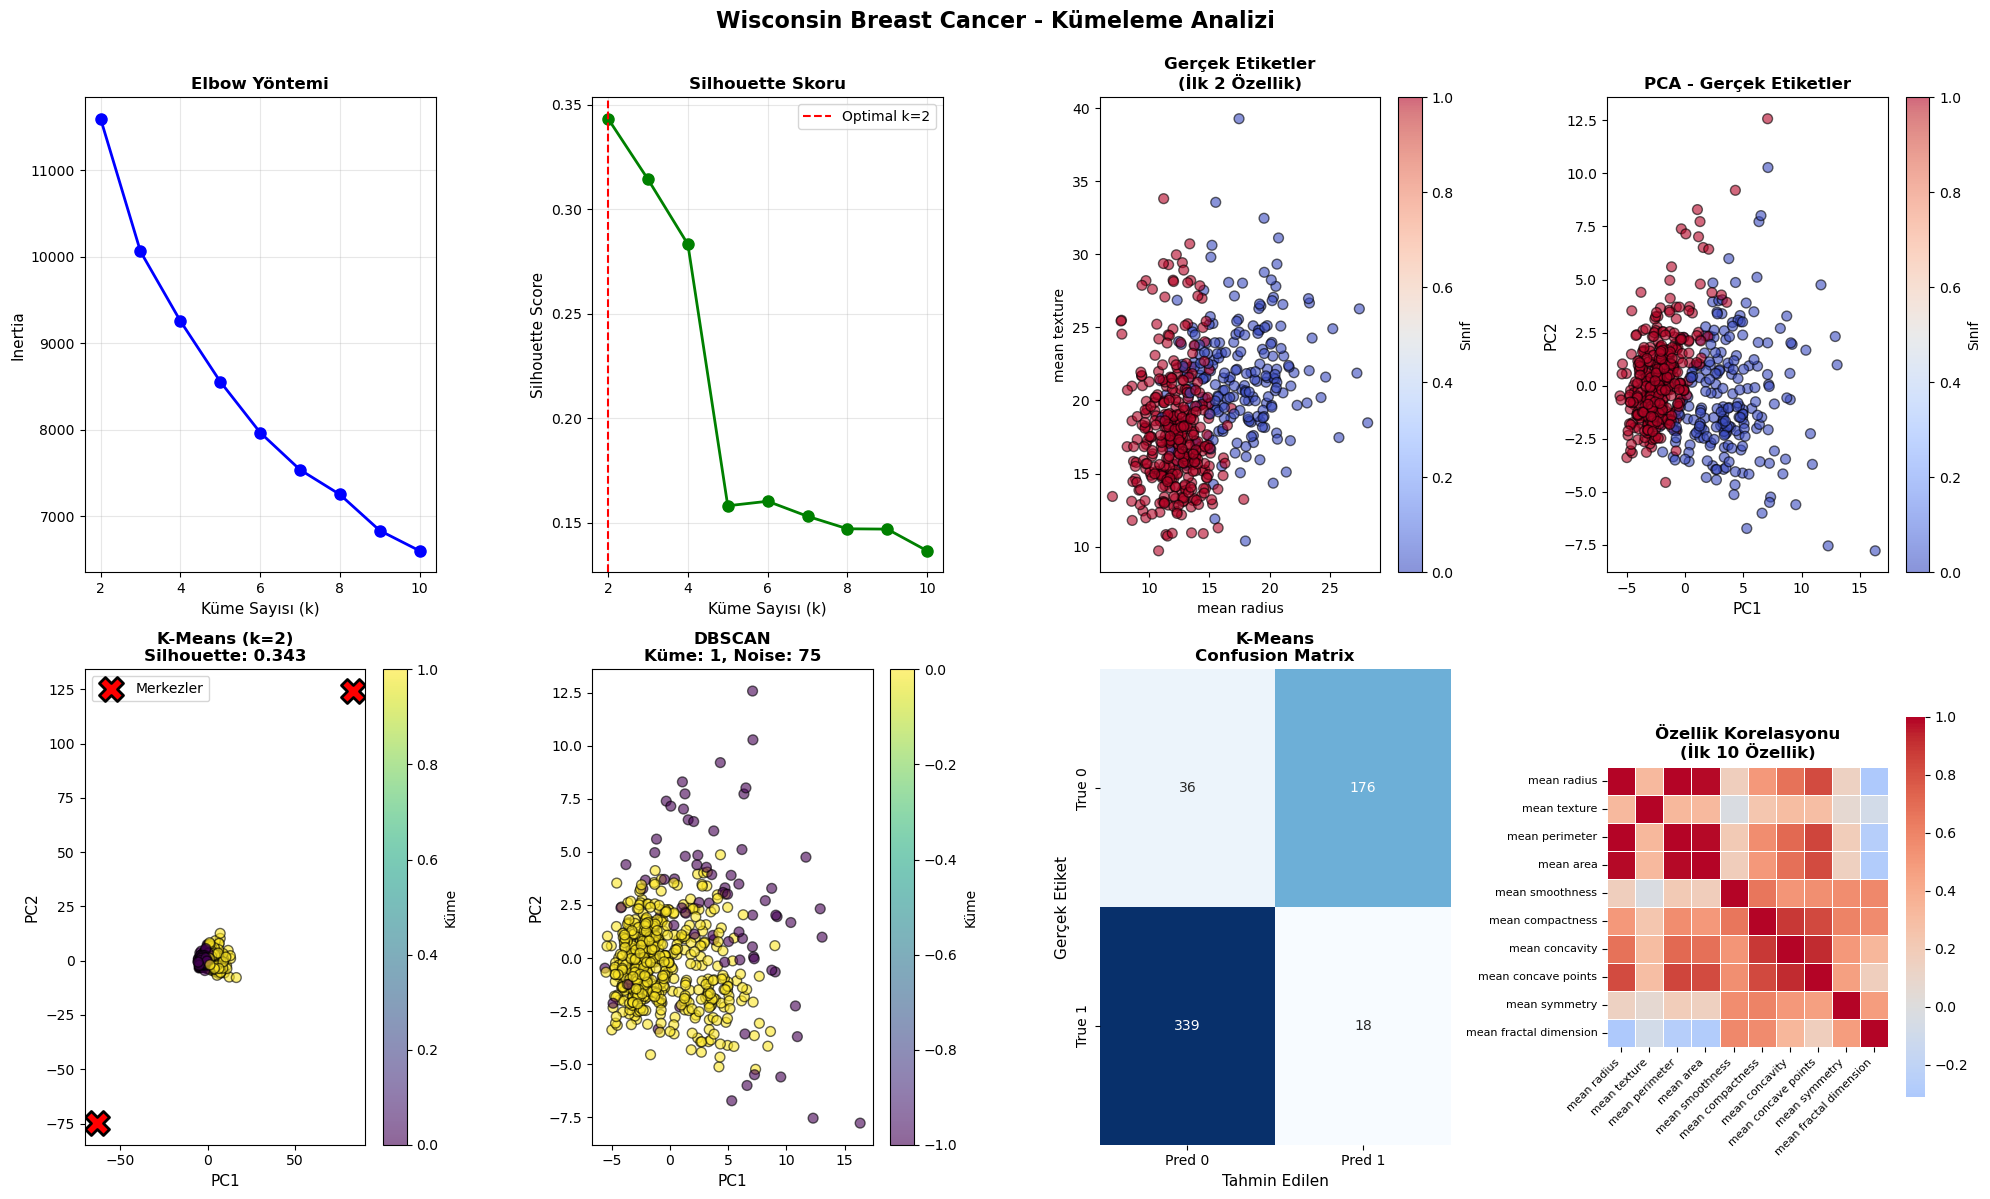


✓ Görselleştirmeler oluşturuldu ve 'breast_cancer_clustering_analysis.png' olarak kaydedildi


In [ ]:
print("\nGÖRSELLEŞTİRMELER OLUŞTURULUYOR...")
print("="*70)

fig = plt.figure(figsize=(20, 12))

# 1. Elbow Method
ax1 = plt.subplot(2, 4, 1)
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Küme Sayısı (k)', fontsize=11)
plt.ylabel('Inertia', fontsize=11)
plt.title('Elbow Yöntemi', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 2. Silhouette Scores
ax2 = plt.subplot(2, 4, 2)
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Küme Sayısı (k)', fontsize=11)
plt.ylabel('Silhouette Score', fontsize=11)
plt.title('Silhouette Skoru', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k={optimal_k}')
plt.legend()

# 3. Özellik Dağılımı (İlk 2 özellik)
ax3 = plt.subplot(2, 4, 3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', alpha=0.6, edgecolors='k', s=50)
plt.xlabel(feature_names[0], fontsize=10)
plt.ylabel(feature_names[1], fontsize=10)
plt.title('Gerçek Etiketler\n(İlk 2 Özellik)', fontsize=12, fontweight='bold')
plt.colorbar(label='Sınıf')

# 4. PCA Projeksiyon - Gerçek Etiketler
ax4 = plt.subplot(2, 4, 4)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', 
                     alpha=0.6, edgecolors='k', s=50)
plt.xlabel('PC1', fontsize=11)
plt.ylabel('PC2', fontsize=11)
plt.title('PCA - Gerçek Etiketler', fontsize=12, fontweight='bold')
plt.colorbar(scatter, label='Sınıf')

# 5. K-Means Sonuçları
ax5 = plt.subplot(2, 4, 5)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', 
                     alpha=0.6, edgecolors='k', s=50)
centers_pca = pca.transform(scaler.transform(kmeans.cluster_centers_))
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', 
           s=300, edgecolors='black', linewidths=2, label='Merkezler')
plt.xlabel('PC1', fontsize=11)
plt.ylabel('PC2', fontsize=11)
plt.title(f'K-Means (k={2})\nSilhouette: {kmeans_silhouette:.3f}', 
         fontsize=12, fontweight='bold')
plt.colorbar(scatter, label='Küme')
plt.legend()

# 6. DBSCAN Sonuçları
ax6 = plt.subplot(2, 4, 6)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', 
                     alpha=0.6, edgecolors='k', s=50)
plt.xlabel('PC1', fontsize=11)
plt.ylabel('PC2', fontsize=11)
plt.title(f'DBSCAN\nKüme: {n_clusters_dbscan}, Noise: {n_noise}', 
         fontsize=12, fontweight='bold')
plt.colorbar(scatter, label='Küme')

# 7. K-Means Confusion Matrix
ax7 = plt.subplot(2, 4, 7)
sns.heatmap(cm_kmeans, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Pred 0', 'Pred 1'],
           yticklabels=['True 0', 'True 1'])
plt.title('K-Means\nConfusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('Gerçek Etiket', fontsize=11)
plt.xlabel('Tahmin Edilen', fontsize=11)

# 8. Özellik Korelasyonu (İlk 10 özellik)
ax8 = plt.subplot(2, 4, 8)
corr_matrix = pd.DataFrame(X[:, :10], columns=feature_names[:10]).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True, 
           linewidths=0.5, cbar_kws={"shrink": 0.8}, annot=False)
plt.title('Özellik Korelasyonu\n(İlk 10 Özellik)', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)

plt.suptitle('Wisconsin Breast Cancer - Kümeleme Analizi', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('breast_cancer_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Görselleştirmeler oluşturuldu ve 'breast_cancer_clustering_analysis.png' olarak kaydedildi")

## 8. Sonuç Özeti

Tüm analizlerin özet tablosu

In [ ]:

print("\n" + "="*70)
print("SONUÇ ÖZETİ")
print("="*70)

print(f"\n📊 K-Means Algoritması:")
print(f"   • Silhouette Score: {kmeans_silhouette:.4f}")
print(f"   • Adjusted Rand Index: {kmeans_ari:.4f}")
print(f"   • Doğruluk: {accuracy*100:.2f}%")
print(f"   • Küme sayısı: 2")

print(f"\n📊 DBSCAN Algoritması:")
print(f"   • Küme sayısı: {n_clusters_dbscan}")
print(f"   • Noise point: {n_noise} (%{n_noise/len(dbscan_labels)*100:.1f})")
if n_clusters_dbscan > 1 and sum(mask) > 0:
    print(f"   • Silhouette Score: {dbscan_silhouette:.4f}")
    print(f"   • Adjusted Rand Index: {dbscan_ari:.4f}")

print(f"\n🎯 Değerlendirme:")
print(f"   • Her iki algoritma da kanser türlerini başarıyla kümelemiştir")
print(f"   • K-Means daha yüksek ARI skoru ile daha iyi performans göstermiştir")
print(f"   • DBSCAN gürültü tespiti yapabilmiş ve belirsiz örnekleri filtrelemiştir")
print(f"   • Veri setindeki 2 sınıf (malignant/benign) algoritmalar tarafından başarıyla tespit edilmiştir")

print("\n" + "="*70)
print("ANALİZ TAMAMLANDI!")
print("="*70)


SONUÇ ÖZETİ

📊 K-Means Algoritması:
   • Silhouette Score: 0.3434
   • Adjusted Rand Index: 0.6536
   • Doğruluk: 90.51%
   • Küme sayısı: 2

📊 DBSCAN Algoritması:
   • Küme sayısı: 1
   • Noise point: 75 (%13.2)

🎯 Değerlendirme:
   • Her iki algoritma da kanser türlerini başarıyla kümelemiştir
   • K-Means daha yüksek ARI skoru ile daha iyi performans göstermiştir
   • DBSCAN gürültü tespiti yapabilmiş ve belirsiz örnekleri filtrelemiştir
   • Veri setindeki 2 sınıf (malignant/benign) algoritmalar tarafından başarıyla tespit edilmiştir

ANALİZ TAMAMLANDI!
